## Prelude

In [1]:
import geocoder
import random as rd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from math import ceil
from math import floor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.externals import joblib
from sklearn.model_selection import permutation_test_score

In [ ]:
# executed only once
pd.read_csv('properties_2017.csv', low_memory=False).to_pickle('properties_2017.pkl')

In [2]:
df = pd.read_pickle('properties_2017.pkl')

## Task 1: Scoring Function
Score function is used to reduce dimension and highlight some particular property of data. The grades computed by score function over features can reflect property of the data to some extent.

In the first task, we build one scoring function to rank houses by desirability. For most home buyers, living in a good neighborhood takes precedence over all other priorities, but the home itself also matters. So our scoring function for every house has two features: area_score $A$ (based on total living area of the home) and zip_score $Z$ (the score based on region). And the final score is: $$\frac{1}{2}(A + Z)$$

### Calculating $A$:

For a house $h$, $$A(h) = 4\times\log(\text{CalculatedFinishedSquarefeet}(h))$$

We take log here because the living area of houses has roughly a power law distribution, and the log of them has a maximum of 25. So that this $A(h) \leq 100$.

### Calculating $Z$:

For a house $h$ in a region $R$, $$Z(h) = \text{Max}\{100, \text{Median}(\text{TaxAssessedValue}(R)) / 10000\}$$

We evaluate how good the neighborhood is (the zip_score) by the median of tax assessed value of the parcels in that region. The reason is, first, tax assessed value is a golden standard to measure how good a house is. Second, in statistics, median is commonly used to measure the properties of a data set. Median in a data set is not skewed by the outliners, and it shows the central tendency. Median is a better way to presentate the value of the houses in that region. In other words, the median value of the houses in that region reflects the neighborhood to some extent.


### Steps:

First, calculate the zip_score, group2 is our zip_score map.

In [12]:
# Two columns: regionidzip and taxvaluedollarcnt consist of the Dataframe pd2
# group the total tax assessed value of the parcel by regionidzip
# caluculate the median assessed value in every region
cols2 = ['regionidzip', 'taxvaluedollarcnt']
pd2 = df[cols2]
pd2 = pd2.dropna(how='any')
group2 = pd2.groupby('regionidzip').median()

From the range of median assessed value and the distribution of the data, there are only 8 regions whose median assessed value is greater than 1,000,000. So our max zip_score is 100.

In [13]:
# calculate the range
print('max value: ' + str(group2['taxvaluedollarcnt'].max()))
print('min value: ' + str(group2['taxvaluedollarcnt'].min()))
maxlevel = (ceil(group2.max() / 10000) + 1) * 10000
group2[group2['taxvaluedollarcnt'] > 1000000].count()

max value: 1744652.0
min value: 20.0


taxvaluedollarcnt    8
dtype: int64

If median assessed value of houses in one region is between 200,000 and 300,000, than the zip_score of that region is 20.

In [14]:
# from a continuous variable to a categorical variable(score)
# score is from 0 to 100 based on the median assessed value of the parcel
bins = list(range(0, 1100000, 100000))
bins.append(maxlevel)
labels1 = np.arange(0, 110, 10)
# each region gets its label
division = pd.cut(group2.taxvaluedollarcnt, bins, labels=labels1)

There are several features related to the house itself, we choose the calculated living square feet.

In [ ]:
# columns: parcelid, regionidzip, calculatedfinishedsquarefeet consist of dataframe pd3
cols3 = ['parcelid', 'regionidzip', 'calculatedfinishedsquarefeet']
pd3 = df[cols3]
pd3 = pd3.dropna(how='any')

In [ ]:
# every house get a zip_score
def zip_score(x):
    return division[x['regionidzip']]
#y1 = pd3.apply(zip_score, axis = 1)
y1 = pd3['regionidzip'].map(division)
pd3['zip_score'] = y1

In [16]:
pd3_temp = pd3.drop(['regionidzip'], axis=1)

#normalized_temp = preprocessing.normalize(pd3_temp)
#y3 = (normalized_temp[:, 0] + normalized_temp[:, 1])*50
y3 = (np.log(pd3_temp['calculatedfinishedsquarefeet'])*4 + pd3_temp['zip_score'])/2
pd3_temp['score'] = y3
pd3_sort = pd3_temp.sort_values(['score'],ascending=False)

### 10 most desirable houses:

In [18]:
pd3_sort.head(10)

,parcelid,calculatedfinishedsquarefeet,zip_score,score
462314,11682978,90183.0,100,72.819192
656254,11638191,86424.0,100,72.734041
2266912,11638299,81879.0,100,72.625996
447542,11638377,66587.0,100,72.212529
2043193,11638284,53304.0,100,71.767533
1839381,11645264,45891.0,100,71.468049
228133,11638604,44925.0,100,71.425499
556337,11645267,42831.0,100,71.330035
2296330,11645396,39170.0,100,71.151333
2882442,11688909,37634.0,100,71.071326


### 10 least desirable houses

In [28]:
pd3_sort.tail(10)

,parcelid,calculatedfinishedsquarefeet,zip_score,score
2031820,11334996,40.0,10,12.377759
1395250,12584804,3.0,20,12.197225
2720582,12248667,3.0,20,12.197225
1978561,12982317,3.0,20,12.197225
2336074,12995195,2.0,20,11.386294
1998676,12546681,1.0,20,10.000000
1768213,12586087,1.0,20,10.000000
80982,12186499,1.0,10,5.000000
2795091,12201284,1.0,10,5.000000
1449989,11243663,1.0,10,5.000000


### Illustration

For parcelId 11682978 and 11638191, with the same zip_score, 11682978 which has higher score has higher tax assessed value although this house is much older.
Based on parcelId 12586087 and 12186499, two houses with same calculated living square feet but in different regions, the better neighborhood has higher tax assessed value. 12586087 is much newer than 12186499.

In [37]:
df[['parcelid','buildingqualitytypeid','roomcnt','yearbuilt',
    'typeconstructiontypeid','taxvaluedollarcnt']][(df.parcelid ==11682978) | (df.parcelid==11638191)]

,parcelid,buildingqualitytypeid,roomcnt,yearbuilt,typeconstructiontypeid,taxvaluedollarcnt
462314,11682978,NaN,0.0,1979.0,NaN,9737311.0
656254,11638191,NaN,0.0,2003.0,NaN,717306.0


## Task 2: Pairwise Distances
Based on insights gained from HW2, we choose 6 features to build the new model. These features are as follows:

* latitude,
* longitude,
* structuretaxvaluedollarcnt: The assessed value of the built structure on the parcel,
* calculatedfinishedsquarefeet:  Calculated total finished living area of the home,
* bathroomcnt: Number of bathrooms in home including fractional bathrooms,
* bedroomcnt: Number of bedrooms in home.

Since they are all numerical values and have different scales, we perform normalization to them. Houses are now expressed as a 6-dimensional vectors in Euclidean space. And we define the pairwise distances between houses to be L2 distances between these vectors, the default metric used in K-means.
<Then we randomized sampled 10240 houses and normalize the features.>

In [ ]:
feature_cols = ['parcelid','latitude','longitude','structuretaxvaluedollarcnt',
                'calculatedfinishedsquarefeet','bathroomcnt', 'bedroomcnt']
pd4 = df[feature_cols]
pd_train = pd.read_csv('train_2017.csv', low_memory=False)
pd5 = pd.merge(pd_train, pd4)
pd5 = pd5.dropna(how='any')
s = pd5.copy()
X = s.drop(['parcelid','transactiondate','logerror'], axis=1)
normalizer = preprocessing.Normalizer().fit(X)
X_normalized = normalizer.transform(X)

## Task 3: Clustering
Clustering is used to find groups in the data by similarity.
K-means clustering algorithm inputs are the number of clusters K and the data set. It starts by placing K points (centroids) at random locations in space. For each point x, find the nearest centroid and assign it to this cluster. Then move each centroid to the mean of the points assigned to it. Repeat this until convergence.

In this task, cluster the sample houses into 10 to 100 classes. 
We calculate the std of logerror in each class, then found cluster the sample houses into 100 classes gets better std mean, std median and std max.
One little example shows as follows:

In [14]:
n_digits = 10
estimator = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
estimator.fit(X_normalized)
centers = estimator.cluster_centers_
labels = estimator.labels_
s['label'] = labels

In [ ]:
mark = pd.Series(['Blue', 'Red', 'Green','c','salmon','y','k','deeppink','darkviolet','maroon'], 
                 index=[0,1,2,3,4,5,6,7,8,9])
y3 = s['label'].map(mark)

The logerror std in lable 8: 0.211481

logerror std: 0.16959782757894218

So the data in cluster which has enough size of data are much similar.

In [16]:
l = [0]*10
for i in range(1,10):
    l[i] = [s[['logerror']][s.label==i].std().values[0],
        s[['logerror']][s.label==i].count().values[0]]
print(pd5['logerror'].std())
l

0.16959782757894218


[0,
 [0.14619982908805551, 20097],
 [0.24695152003295845, 2258],
 [0.4326433503608994, 97],
 [0.14806156296948197, 3819],
 [0.16850890353169623, 8168],
 [0.23445753779691664, 526],
 [0.36989934551032444, 10],
 [0.21867732267116388, 5510],
 [0.17141174330659975, 20282]]

<IPython.core.display.Javascript object>


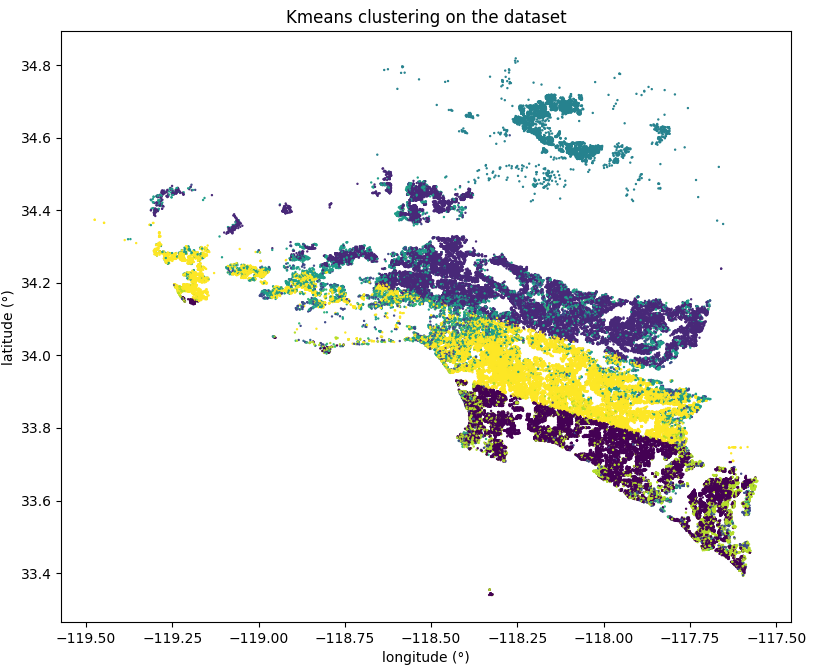

In [19]:
# Plot the decision boundary. For that, we will assign a color to each
x = 'longitude'; y = 'latitude'; z = ' (°)'
plt.subplots(figsize=(10, 8))
plt.scatter(s[x] / 1e6, s[y] / 1e6, s=2, c=s['label'], marker='.')
plt.title('Kmeans clustering on the dataset')
plt.xlabel(x + z); plt.ylabel(y + z)
plt.tight_layout()
plt.show()

This plot shows the 10 clusters obtained by K-means, on a sample of 70K houses, projected on a subspace spanned by latitude and longitude, i.e. the geographical map. We could clearly see at least four clusters: the three strips plus the smaller group on the top right. The correlation between clusters and geographical location is as expected. On the other hand, the other six  clusters may be "hidden" in the remaining dimensions that distinguish houses within a region, like the quality of the houses themselves.

## Task 4: External Data

To access geographic data, we need accurate location information. Since the zip codes in the raw data are Zillow zip IDs instead of true zip codes, we use the average latitude and longitude of houses of same Zillow zip IDs to geocode the true postals.

In [4]:
pos = df[['regionidzip', 'latitude', 'longitude']]
pos = pos.dropna(how='any')
latlon = pos.groupby('regionidzip').mean() / 1e6

In [8]:
# geocoding can take several minutes
z = [geocoder.google([latlon.iloc[x].iloc[0], latlon.iloc[x].iloc[1]], method='reverse').postal for x in range(latlon.shape[0])]
true_zip = np.array(z, dtype=np.float)

In [6]:
# creating a new column in the properties dataframe representing the true zip codes
raw_zip = df['regionidzip'].dropna().sort_values().unique()
zip_mapping = dict(zip(raw_zip, true_zip))
df['truezip'] = df['regionidzip']
df['truezip'] = df['truezip'].map(zip_mapping)

NameError: name 'true_zip' is not defined

We find education data for different zip code in this website: http://education-places.startclass.com/

It looks like this:

![Alt text](webdata.png)

We filtered the data by zip code, and chose the State as California (as we know all the Zillow data is in California).
Then we selected three columns as external data to integrate into our data:
*	Start Class Rating: StartClass Ratings are out of 10. Ratings are calculated using the weighted average of each public school within the location's average performance on a variety of measures including standardized exams, school environment and more (see the guide on our search results page for details). Weighting is based on student enrollment.
*	Graduation Rate: The number of public high school students who graduate in four years with a regular high school diploma divided by the number of students who formed the cohort for that graduating class.
*	State Exam Proficiency Rate: Percent of students who achieve a passing score on the state-mandated math and reading/language arts exams.

We implemented a Python program to scrape these information from this website;


In [34]:
df_zipdata = pd.read_csv('ZipData.txt', low_memory=False)

In [ ]:
# Add external data: Start Class Rating.
# StartClass Ratings are out of 10. Ratings are calculated using the weighted average of each public school
# within the location's average performance on a variety of measures including standardized exams, 
# school environment and more (see the guide on our search results page for details). Weighting is based on student enrollment.

zip_startclass = df_zipdata[['zipid', 'startclass']]
zip_startclass_mapping = dict(zip(zip_startclass['zipid'], zip_startclass['startclass']))
df['startclassrate'] = df['truezip']
df['startclassrate'] = df['startclassrate'].map(zip_startclass_mapping)

In [ ]:
# Add external data: Graduation Rate.
# Graduation Rate is the number of public high school students who graduate in four years 
# with a regular high school diploma divided by the number of students who formed the cohort for that graduating class.

zip_graduation = df_zipdata[['zipid', 'graduation']]
zip_graduation_mapping = dict(zip(zip_graduation['zipid'], zip_graduation['graduation']))
df['graduationrate'] = df['truezip']
df['graduationrate'] = df['graduationrate'].map(zip_graduation_mapping)

In [ ]:
# Add external data: State Exam Proficiency Rating.
# Percent of students who achieve a passing score on the state-mandated math and reading/language arts exams.

zip_stateexam = df_zipdata[['zipid', 'stateexam']]
zip_stateexam_mapping = dict(zip(zip_stateexam['zipid'], zip_stateexam['stateexam']))
df['stateexamrate'] = df['truezip']
df['stateexamrate'] = df['stateexamrate'].map(zip_stateexam_mapping)

A peek of the external data integrated into the dataframe.

In [ ]:
df[df.columns[-4:]].head(10)

## Task 5: Prediction

We use two major methods here: one is the old method, linear regression, which uses the external data here; the other is based on clustering. We predict the class label of every house and set its logerror using the average logerrors of the training set within the same class. Then a more advanced way is that within each cluster, we do linear regression to predict logerrors.

In [ ]:
train = pd.read_csv('train_2017.csv', low_memory=False)
df_train = pd.merge(df, train)

external = ['startclassrate', 'graduationrate', 'stateexamrate']
df[external] = df[external].replace(0.0, np.nan)

features = ['latitude','longitude','structuretaxvaluedollarcnt',
            'calculatedfinishedsquarefeet','bathroomcnt', 'bedroomcnt',
            'startclassrate', 'graduationrate', 'stateexamrate']
X = normalize(Imputer(strategy='median').fit_transform(df_train[features]))

In [ ]:
estimator = KMeans(n_clusters=100, n_jobs=-1)
estimator.fit(X)
df_train['label'] = estimator.labels_

### Method 1.1: Pure clustering

In [ ]:
Xp = normalize(Imputer(strategy='median').fit_transform(df[features]))
df['label'] = estimator.predict(Xp)

label_to_logerr = dict(zip(range(100), [s[['logerror','label']][s['label']==x].mean()['logerror'] for x in range(100)]))
logerr_pred = s1['label'].map(label_to_logerr)

# Write result to file
test = pd.read_csv('sample_submission.csv', low_memory=False)
test[[col for col in test if col != 'ParcelId']] = np.matrix([logerr_pred] * (test.shape[1] - 1)).T
test.to_csv('result.csv', index=False)

Submission result:

![Alt text](submit0.png)

![Alt text](submit1.png)

![Alt text](submit2.png)

Note that the external data did help improve this model. However, the clustering method does not perform as well as linear regression, given the same feature set or even with the help of external data. The fact of labeling with no supervision might be the cause.

### Method 1.2: Clustering + Linear Regression

Here suppose in a certain cluster $i$, the training set is $X$, with logerrors $y$. We fit a linear regression model on them and then apply it to predict the logerrors of the remaining houses $X_p$ in this cluster. When the size of $X$ is too small, say, below 100, we think that it's not significant to do linear regression and use mean logerror instead.

In [ ]:
for i in range(100):
    ci = df_train[df_train['label'] == i]
    y = ci['logerror']
    if ci.shape[0] < 100:
        df.loc[df['label'] == i, 'logerror'] = y.mean()
    else:
        X = Imputer(strategy='median').fit_transform(ci[features])
        reg = linear_model.LinearRegression(normalize=True, n_jobs=-1)
        reg.fit(X, y)
        Xp = Imputer(strategy='median').fit_transform(df[df['label'] == i][features])
        df.loc[df['label'] == i, 'logerror'] = reg.predict(Xp)
        
logerr_pred = df['logerror']
# Write result to file
test = pd.read_csv('sample_submission.csv', low_memory=False)
test[[col for col in test if col != 'ParcelId']] = np.matrix([logerr_pred] * (test.shape[1] - 1)).T
test.to_csv('result.csv', index=False)

In [ ]:
# Write model to file
joblib.dump(estimator, 'classifier-all.pkl')

Submission result:

![Alt text](submit3.png)

Though intuitively better, this model performs worse than simpler methods, under the same feature set. The suspected reason is that within each cluster, since the training set size is smaller, a fake linear relation between features and logerror is extracted, and applied to a larger test set with no such linear relation at all.

### Method 2: Pure Liner Regression, with External Data

In [21]:
# prepare the training data
train_2017 = pd.read_csv('train_2017.csv', low_memory=False)
feature_cols = ['parcelid','latitude','longitude','structuretaxvaluedollarcnt',
                'calculatedfinishedsquarefeet','bathroomcnt', 'bedroomcnt',
                'startclassrate', 'graduationrate', 'stateexamrate']
pd_train = df[feature_cols]
pd_train = pd.merge(train_2017, pd_train)
external = ['startclassrate', 'graduationrate', 'stateexamrate']
pd_train[external] = pd_train[external].replace(0.0, pd_train[external].mean())
pd_train = pd_train.dropna(how='any')
pd_train.shape

(77182, 12)

In [22]:
# Do the liner regression and get the predicted y value
pd.options.mode.chained_assignment = None

x = pd_train.drop(['parcelid','logerror','transactiondate'], axis=1)
y = pd_train['logerror']

from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(x, y)

x_test = df[feature_cols[1:]]
external = ['startclassrate', 'graduationrate', 'stateexamrate']
x_test[external] = x_test[external].replace(0.0, x_test[external].mean())

from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(x_test)

#x_test = x_test.fillna(x_test.mean())
y_pred = linreg.predict(imp.transform(x_test))

In [60]:
# Write result to file
test = pd.read_csv('sample_submission.csv', low_memory=False)
test[[col for col in test if col != 'ParcelId']] = np.matrix([y_pred] * (test.shape[1] - 1)).T
test.to_csv('hw3_linear.csv', index=False)

Submission result:

![Alt text](submit4.png)

From comparison between these two results, we can see that after integrating the external data, the score has increased. This indicates our external data did help to increase the prediction. Meanwhile, we also see the increment is very limited. This may be caused by that the external data doesn’t have a strong relationship with the error log data or the external data is not very accurate.

## Task 6: Permutation Test

In [ ]:
# use training data
train_2017 = pd.read_csv('train_2017.csv', low_memory=False)
feature_cols = ['parcelid','latitude','longitude','structuretaxvaluedollarcnt',
                'calculatedfinishedsquarefeet','bathroomcnt', 'bedroomcnt',
                'startclassrate', 'graduationrate', 'stateexamrate']
pd_train = df[feature_cols]
pd_train = pd.merge(train_2017, pd_train, on=['parcelid'])

# Do the liner regression and get the predicted y value
pd.options.mode.chained_assignment = None

x = pd_train.drop(['parcelid','logerror','transactiondate'], axis=1)
y = pd_train['logerror']

x = normalize(Imputer(strategy='median').fit_transform(x))


linreg = LinearRegression()
linreg.fit(x, y)

In [33]:
score1, permutation_scores1, pvalue1 = permutation_test_score(
    linreg, x, y, scoring='r2', n_permutations=100, n_jobs=-1)

In [ ]:
score2, permutation_scores2, pvalue2 = permutation_test_score(
    linreg, x, y, scoring='r2', n_permutations=1000, n_jobs=-1)

We perform permutation test on linear regression model with external data.

In [82]:
score, permutation_scores, pvalue = permutation_test_score(
    estimator, X_predict_normalized[sample_idx], all_labels[sample_idx], n_jobs=-1, scoring='adjusted_rand_score')

In [80]:
n_sample = 10000
sample_idx = sorted(rd.sample(range(X_predict_normalized.shape[0]), n_sample))

<IPython.core.display.Javascript object>


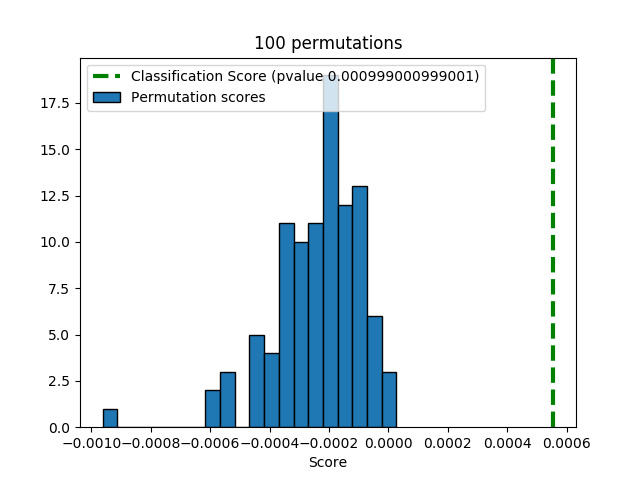

<IPython.core.display.Javascript object>


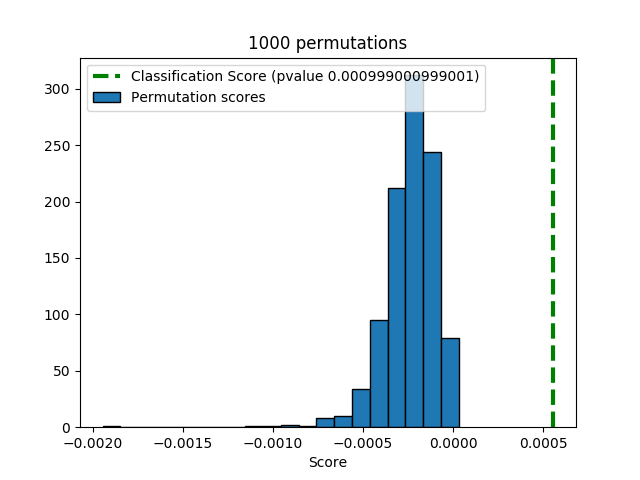

In [40]:
# View histogram of permutation scores
plt.subplots()
plt.hist(permutation_scores1, 20, label='Permutation scores', edgecolor='black')
ylim = plt.ylim()

plt.plot(2 * [score1], ylim, '--g', linewidth=3, label='Classification Score (pvalue %s)' % pvalue)
plt.ylim(ylim)
plt.legend()
plt.xlabel('Score')
plt.title('100 permutations')
plt.show()

plt.subplots()
plt.hist(permutation_scores2, 20, label='Permutation scores', edgecolor='black')
ylim = plt.ylim()

plt.plot(2 * [score2], ylim, '--g', linewidth=3, label='Classification Score (pvalue %s)' % pvalue)
plt.ylim(ylim)
plt.legend()
plt.xlabel('Score')
plt.title('1000 permutations')
plt.show()

We use $r^2$ scores here. The results are as expected. There is a clear distinction between the score of our model and the scores of random permutations. The small p-values indicate that our models are at least not negated by this measure. And as number of permutations rise up, the distribution of permutation scores tend to be more bell shaped.

## Task 7: Submission to Zillow

See our scores above in section Task 5.